In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.lines as lines

plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'xtick.labelsize': 7})
plt.rcParams.update({'ytick.labelsize': 7})

sns.set_style("ticks")
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5



In [14]:
# set some things
num_muts_total = 15

num_mutations_H1 = 15
order_H1 = 4
num_term_list_H1 = np.array([int(comb(num_mutations_H1,i)) for i in range(1,order_H1+1)])
total_params_H1 = sum(num_term_list_H1)
order_start_indices_H1 = list(np.cumsum(num_term_list_H1)+1)
order_start_indices_H1.insert(0,1)
print(num_term_list_H1,total_params_H1)
print(order_start_indices_H1)


mut_names = ['339','371','373','375','417','440','446','477','478','484','493','496','498','501','505']

H1_color = '#929591'

ep_type = 'biochem'

[  15  105  455 1365] 1940
[1, 16, 121, 576, 1941]


In [15]:
# read first and second order effects for H1
first_coefs_H1 = np.zeros(num_muts_total)
first_coefs_H1_stderr = np.zeros(num_muts_total)
first_coefs_H1_ci = np.zeros((num_muts_total,2))
second_coefs_H1_matrix = np.zeros((num_muts_total,num_muts_total))
second_coefs_H1_matrix_sigmask = np.zeros((num_muts_total,num_muts_total))
 
with open('ACE2_4order_biochem.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    header = next(coef_reader)
    intercept = next(coef_reader)
    for i in range(num_term_list_H1[0]):
        row = next(coef_reader)
        index = int(row[0])-1
        first_coefs_H1[index] = float(row[1])
        first_coefs_H1_stderr[index] = float(row[2])
        first_coefs_H1_ci[index,:] = [float(row[4]),float(row[5])]
    for i in range(num_term_list_H1[1]):
        row = next(coef_reader)
        i1,i2 = row[0].split(',')
        index1 = int(i1)-1
        index2 = int(i2)-1
        second_coefs_H1_matrix[index1][index2] = float(row[1])
        second_coefs_H1_matrix[index2][index1] = float(row[1])
        if float(row[4])*float(row[5]) > 0.0:
            second_coefs_H1_matrix_sigmask[index1][index2] = float(row[1])
            second_coefs_H1_matrix_sigmask[index2][index1] = float(row[1])
        
    readfile.close()

print(first_coefs_H1)

[ 0.03200919 -0.02624295 -0.04073193  0.11245214 -0.41070577  0.18860459
 -0.35449279  0.34941246  0.00872446 -0.10109456 -0.19010525 -0.81334098
 -0.12832195  0.37262696 -0.89818963]


## plot first order effects

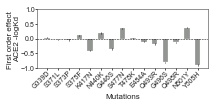

In [22]:
full_mut_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3,1.5))
plt.tick_params(size=2,labelsize=7,length=2.5,pad=0)
#plt.tick_params(axis='x',rotation=45)
x = np.arange(15)
width = 0.5
ymax = 1

for xval in x:
    plt.bar(xval,first_coefs_H1[xval],width,color=H1_color,linewidth=0.25)

    plt.plot([xval,xval],
             [first_coefs_H1[xval]-first_coefs_H1_stderr[xval],first_coefs_H1[xval]+first_coefs_H1_stderr[xval]],'k-',linewidth=0.5)


plt.xticks(x,full_mut_names,fontsize=7,rotation=45,ha='right',rotation_mode="anchor")
plt.ylim([-1,1])
plt.xlabel('Mutations',fontsize=8)
plt.ylabel('First order effect \nACE2 -logKd',labelpad=0.5,fontsize=8)
legend_elements = [Patch(facecolor=H1_color, label='ACE2 affinity')]
#plt.legend(handles=legend_elements,fontsize=7,bbox_to_anchor=(0.5, 1.1), loc='center',ncol=1,frameon=False)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)

plt.tight_layout()
plt.savefig('images/RBD_linear_effects.pdf')


## plot second order effects

-0.30724930493579383 0.7935995220626427


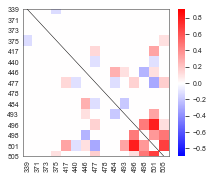

In [29]:
# heatmap of second order effects
full_mut_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']

# combine coefs into one matrix
coefs_to_plot = np.full((num_mutations_H1,num_mutations_H1),np.nan)
for i in range(num_mutations_H1):
    for j in range(i,num_mutations_H1):
        # upper diagonal H1
        coefs_to_plot[i,j] = second_coefs_H1_matrix_sigmask[i,j]
        # lower diagonal H3
        coefs_to_plot[j,i] = second_coefs_H1_matrix_sigmask[i,j]
print(np.nanmin(coefs_to_plot),np.nanmax(coefs_to_plot))

sns.set_style("white",{"axes.facecolor": "firebrick"})
plt.figure(figsize=(3,2.5))

ax = sns.heatmap(coefs_to_plot,cmap='bwr',xticklabels=mut_names,yticklabels=mut_names,vmin=-0.9,vmax=0.9,
                linewidths=0,linecolor='w')
for _, spine in ax.spines.items():
    spine.set_visible(True)
    
line = lines.Line2D([0,num_mutations_H1], [0,num_mutations_H1],
                    lw=0.5, color='black', axes=ax)
ax.add_line(line)
ax.tick_params(pad=0)
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.tight_layout() #rect=[0, 0.03, 1, 0.95])
plt.savefig('images/RBD_2ndorder_effects.pdf')
plt.show()